## Import packages

In [1]:
import mahotas
import cv2 as cv
import numpy as np
import pandas as pd
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
from ast import literal_eval
import random
from scipy.signal import find_peaks

%load_ext autoreload

In [2]:
%autoreload 2

### From pervious phage experiment - not the best masks

In [3]:
test_df = pd.read_csv('./example/csv/2022_04_22_PC_data_epoch_20_prob_99.csv', usecols=["trench_id", "time_(mins)", "label", "image_intensity", "major_axis_length"])
display(test_df.head(10))

major_axis_length  label  \
0          53.914721      1   
1          23.095973      2   
2          46.195044      3   
3          26.433404      4   
4          24.294469      5   
5          31.235148      6   
6          27.925252      7   
7          23.344981      8   
8          44.145032      9   
9          23.171290     10   

                                     image_intensity  trench_id  time_(mins)  
0  [[   0    0    0 1604 1629    0    0    0    0...          0            0  
1  [[2157 2356    0    0    0    0]\r\n [1936 215...          0            0  
2  [[   0 1920 2044 2281    0    0    0    0]\r\n...          0            0  
3  [[   0    0    0 2027    0    0]\r\n [   0    ...          0            0  
4  [[   0    0    0    0    0 2082 1947]\r\n [   ...          0            0  
5  [[   0    0    0 2133 2185    0]\r\n [   0    ...          0            0  
6  [[   0    0    0    0 2052 2238    0]\r\n [   ...          0            0  
7  [[   0    0    0 1951    0    0]\r\n [   0    ...          0            0  
8  [[   0    0    0 1774    0    0    0    0    0...          0            0  
9  [[1952 1905 1985    0    0    0    0    0]\r\n...          0            0

In [4]:
# pick the PC image array of the mother cell of one trench
array_df = test_df.loc[(test_df["trench_id"] == 1)].loc[(test_df["label"] == 1)]["image_intensity"].reset_index(drop=True)
length_df = test_df.loc[(test_df["trench_id"] == 1)].loc[(test_df["label"] == 1)]["major_axis_length"].reset_index(drop=True)

# random other cells
array_df_2 = test_df.loc[(test_df["trench_id"] == 1)].loc[(test_df["label"] <= 3)]["image_intensity"].reset_index(drop=True)

In [5]:
def extract_from_string(array):
    return np.asarray(literal_eval(array.replace( '[   ' , '[' ).replace( '[  ' , '[' ).replace( '    ' , ',' ).replace( '   ' , ',' ).replace( '  ' , ',' ).replace( ' ' , ',' )), dtype=np.float32)

In [6]:
mother_PC = [extract_from_string(array_df[i]) for i in range(len(array_df))]
mother_masks = [x.astype(bool) for x in mother_PC]

control_PC = [extract_from_string(array_df_2[i]) for i in range(len(array_df_2))]
control_masks = [x.astype(bool) for x in control_PC]

## have a look a the cells

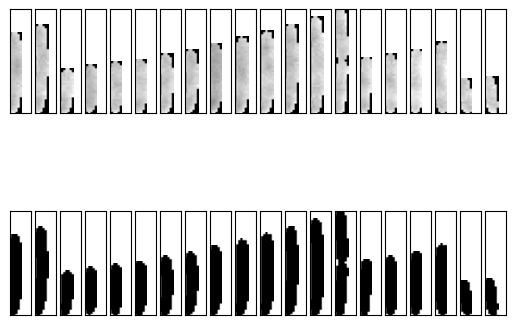

In [7]:
fig, axes = plt.subplots(2, 20)
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 10)
custom_ylim = (0, 50)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
for i in range(20):
    axes[0][i].imshow(mother_PC[i], cmap="gray")
    axes[1][i].imshow(mother_masks[i], cmap="binary")
    axes[0][i].set_xticks([])
    axes[1][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[1][i].set_yticks([])
plt.show()

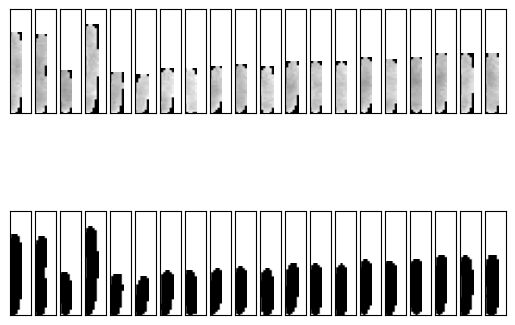

In [8]:
fig, axes = plt.subplots(2, 20)
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 10)
custom_ylim = (0, 50)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
for i in range(20):
    axes[0][i].imshow(control_PC[i], cmap="gray")
    axes[1][i].imshow(control_masks[i], cmap="binary")
    axes[0][i].set_xticks([])
    axes[1][i].set_xticks([])
    axes[0][i].set_yticks([])
    axes[1][i].set_yticks([])
plt.show()

## Get division point of the mother cell

(array([ 1, 13, 17, 27, 36, 44, 54], dtype=int64), {})


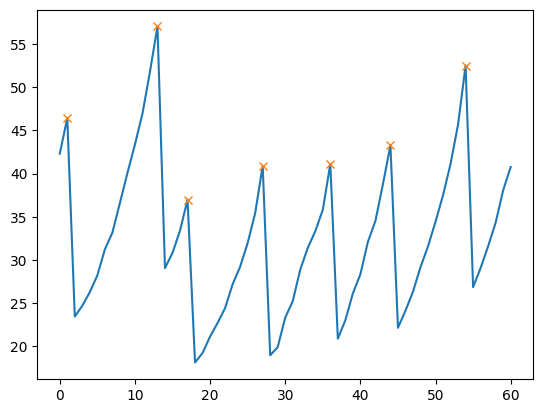

In [9]:
mother_length = [length_df[i] for i in range(len(array_df))]
peaks = find_peaks(mother_length)
print(peaks)
plt.plot(mother_length)
plt.plot(peaks[0], [mother_length[i] for i in peaks[0]], 'x')
plt.show()

## Let's try zernike and hu moments
## Also try haralick features

In [11]:
mother_zernikes = [mahotas.features.zernike_moments(im, 30) for im in mother_masks]
mother_hus = [cv.HuMoments(cv.moments(im)) for im in mother_PC]

mother_haralicks = [mahotas.features.haralick(im.astype(np.uint8)) for im in mother_PC]

# also take some other cells for comparison
control_zernikes = [mahotas.features.zernike_moments(im, 30) for im in control_masks]
control_hus = [cv.HuMoments(cv.moments(im)) for im in control_PC]

control_haralicks = [mahotas.features.haralick(im.astype(np.uint8)) for im in control_PC]

## Use descriptor on half of the image at division points (for the purpose of simulating division

In [12]:
half_zernikes = [mahotas.features.zernike_moments(im[:int(im.shape[0]/2), :], 30) for im in mother_masks]
half_hus = [cv.HuMoments(cv.moments(im[:int(im.shape[0]/2), :])) for im in mother_PC]

half_haralicks = [mahotas.features.haralick(im.astype(np.uint8)[:int(im.shape[0]/2), :]) for im in mother_PC]

In [13]:
# print([np.sum(abs(z)) for z in mother_zernikes])
# print([np.sum(abs(h)) for h in mother_hus])

In [14]:
# plt.plot(mother_zernikes)
# plt.show()

## Look at the variation in these moments over time

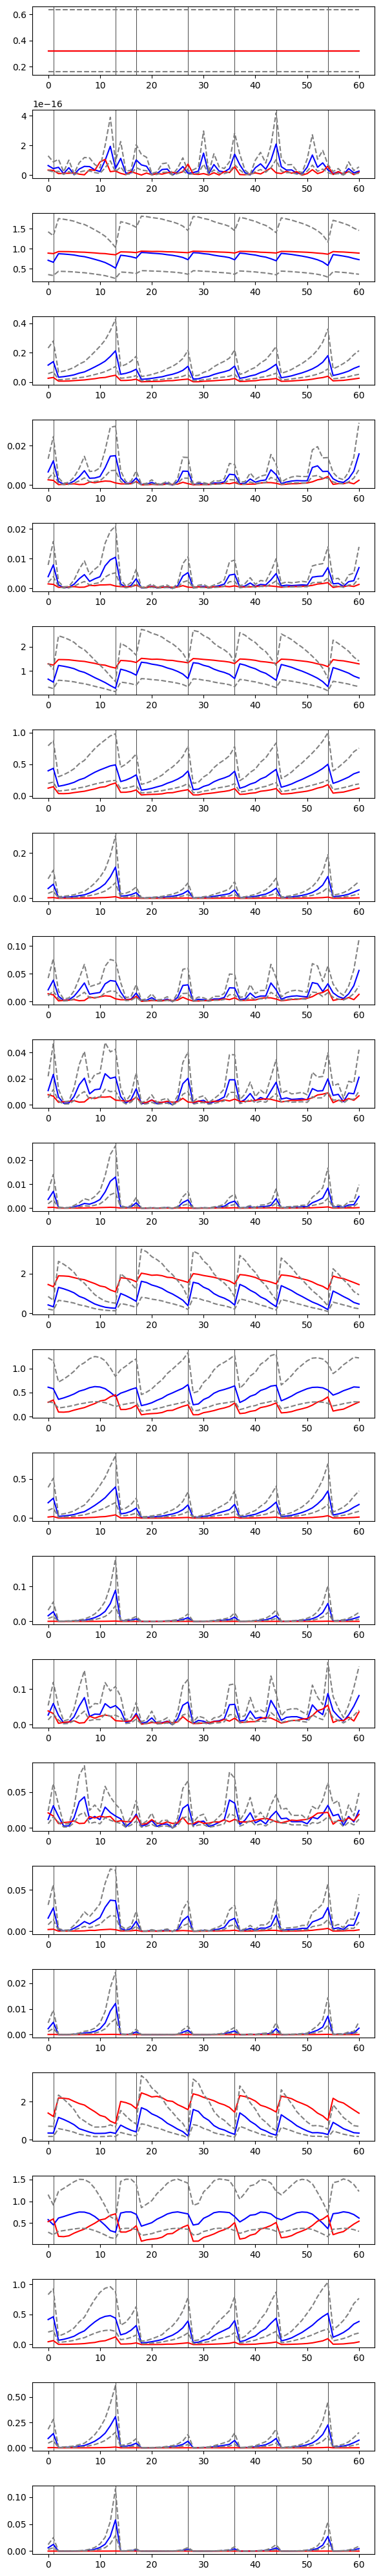

In [15]:
fig, axes = plt.subplots(25, 1, figsize=(6, 40))
for i in range(25):
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].plot([z.flatten()[i] for z in mother_zernikes], 'b')
    axes[i].plot([z.flatten()[i] for z in half_zernikes], 'r')
    axes[i].plot([z.flatten()[i]/2 for z in mother_zernikes], color='gray', linestyle='--')
    axes[i].plot([z.flatten()[i]*2 for z in mother_zernikes], color='gray', linestyle='--')
    
plt.tight_layout()
plt.show()

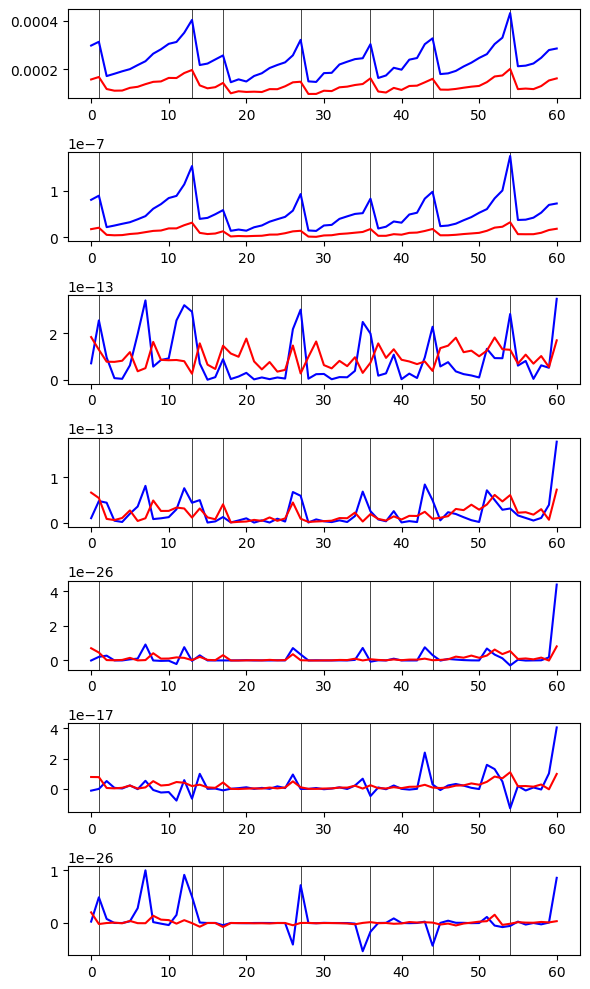

In [16]:
fig, axes = plt.subplots(7, 1, figsize=(6, 10))
for i in range(7):
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].plot([h.flatten()[i] for h in mother_hus], 'b')
    axes[i].plot([h.flatten()[i] for h in half_hus], 'r')
    # axes[i].axhline(max([h.flatten()[i] for h in mother_hus])/2, color='g', linestyle='--')
plt.tight_layout()
plt.show()

## Check the Euclidean distance between frames (each moments), note the difference in the order of magnitude

In [35]:
distance_mother_zer = [mother_zernikes[i+1] - mother_zernikes[i] for i in range(len(mother_zernikes)-1)]
distance_half_zer = [mother_zernikes[i+1] - half_zernikes[i] for i in range(len(mother_zernikes)-1)]
distance_mother_hu = [mother_hus[i+1] - mother_hus[i] for i in range(len(mother_hus)-1)]
distance_half_hu = [mother_hus[i+1] - half_hus[i] for i in range(len(mother_hus)-1)]
distance_mother_har = [mother_haralicks[i+1] - mother_haralicks[i] for i in range(len(mother_haralicks)-1)]
distance_half_har = [mother_haralicks[i+1] - half_haralicks[i] for i in range(len(mother_zernikes)-1)]

# a control group that is randomly sampling some other cells
distance_control_zer = [mother_zernikes[i+1] - control_zernikes[random.randint(0, len(control_zernikes)-1)] for i in range(len(mother_zernikes)-1)]
distance_control_hu = [mother_hus[i+1] - control_hus[random.randint(0, len(control_hus)-1)] for i in range(len(mother_hus)-1)]
distance_control_har = [mother_haralicks[i+1] - control_haralicks[random.randint(0, len(control_haralicks)-1)] for i in range(len(mother_haralicks)-1)]

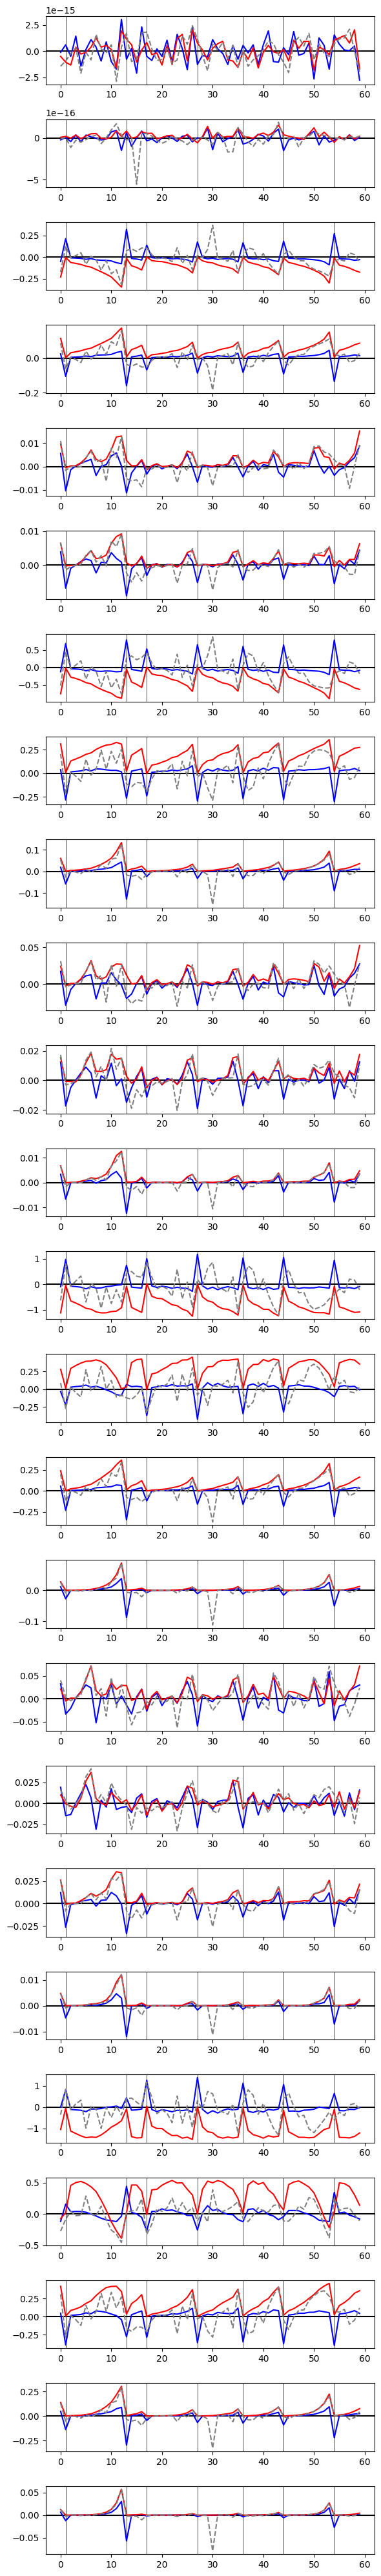

In [18]:
fig, axes = plt.subplots(25, 1, figsize=(6, 40))
for i in range(25):
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].axhline(0, color='black')
    axes[i].plot([z.flatten()[i] for z in distance_mother_zer], 'b')
    axes[i].plot([z.flatten()[i] for z in distance_half_zer], 'r')
    axes[i].plot([z.flatten()[i] for z in distance_control_zer], color='gray', linestyle='--')

plt.tight_layout()
plt.show()

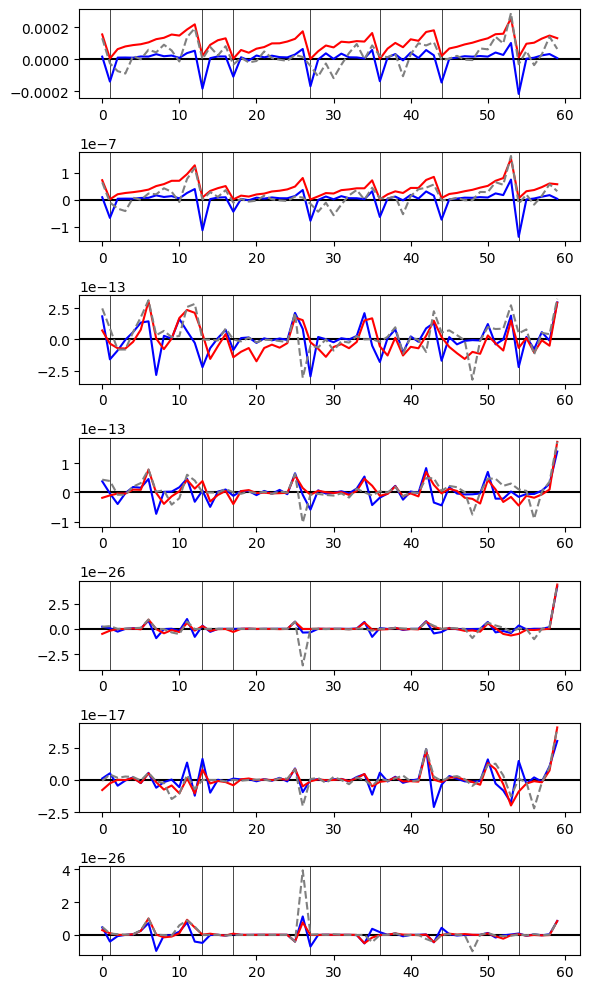

In [19]:
fig, axes = plt.subplots(7, 1, figsize=(6, 10))
for i in range(7):
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].axhline(0, color='black')
    axes[i].plot([h.flatten()[i] for h in distance_mother_hu], 'b')
    axes[i].plot([h.flatten()[i] for h in distance_half_hu], 'r')
    axes[i].plot([h.flatten()[i] for h in distance_control_hu], color='gray', linestyle='--')

plt.tight_layout()
plt.show()

## take half cell at division and compare it with the distance to some random cells

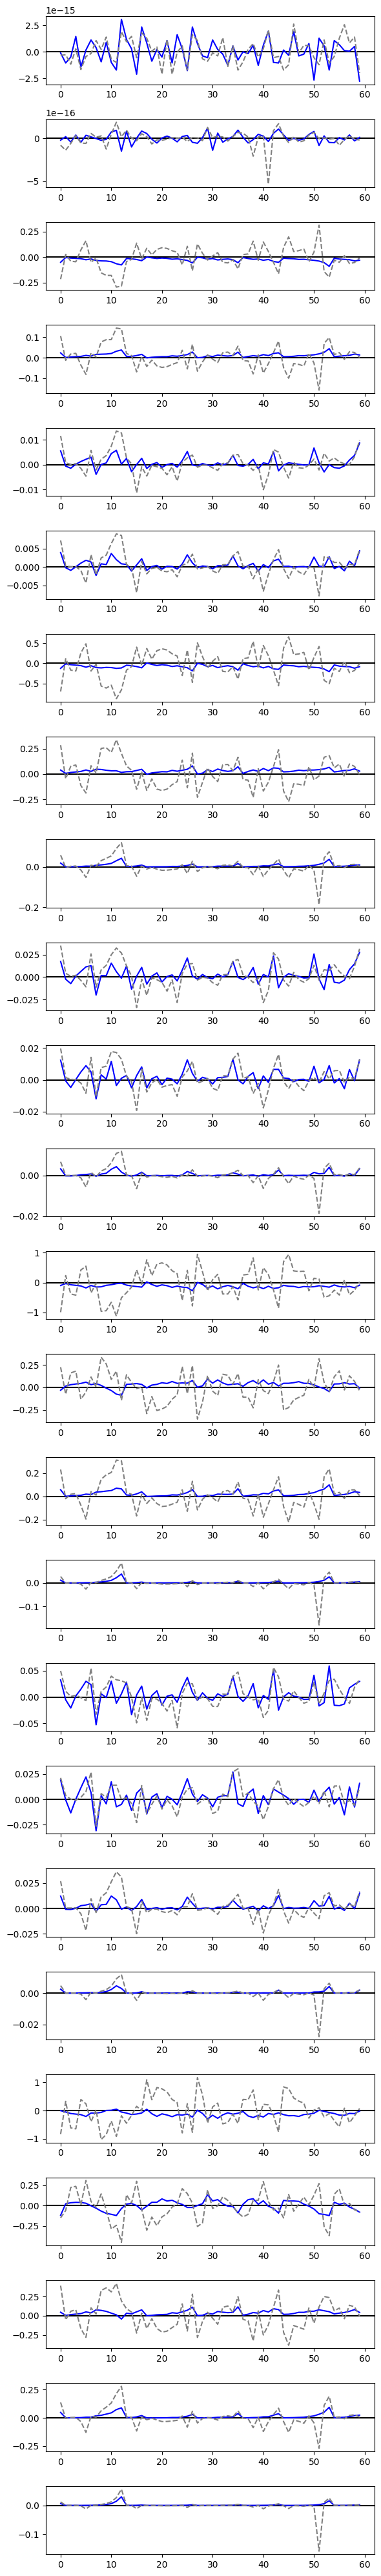

In [52]:
fig, axes = plt.subplots(25, 1, figsize=(6, 40))
for i in range(25):
    
    axes[i].axhline(0, color='black')
    axes[i].plot([distance_mother_zer[z].flatten()[i] if z not in peaks[0] else distance_half_zer[z].flatten()[i] for z in range(len(distance_mother_zer)) ], 'b')
    axes[i].plot([z.flatten()[i] for z in distance_control_zer], color='gray', linestyle='--')
    
plt.tight_layout()
plt.show()

Use Euclidean distance of all the moments - this is an orthogonal descriptor

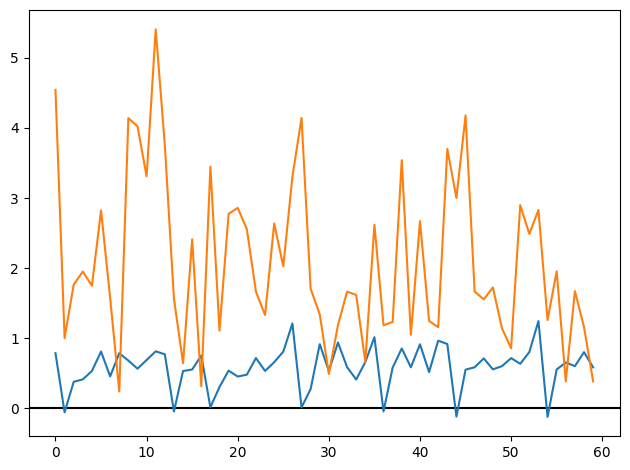

In [57]:
fig, axes = plt.subplots()
euclidean_mother = []
euclidean_control = []
for i in range(25):
    euclidean_mother.append([abs(distance_mother_zer[z].flatten()[i]) if z not in peaks[0] else distance_half_zer[z].flatten()[i] for z in range(len(distance_mother_zer)) ])
    euclidean_control.append([abs(z.flatten()[i]) for z in distance_control_zer])
    
axes.axhline(0, color='black')
axes.plot(np.sum(np.array(euclidean_mother), axis=0))
axes.plot(np.sum(np.array(euclidean_control), axis=0))
plt.tight_layout()
plt.show()

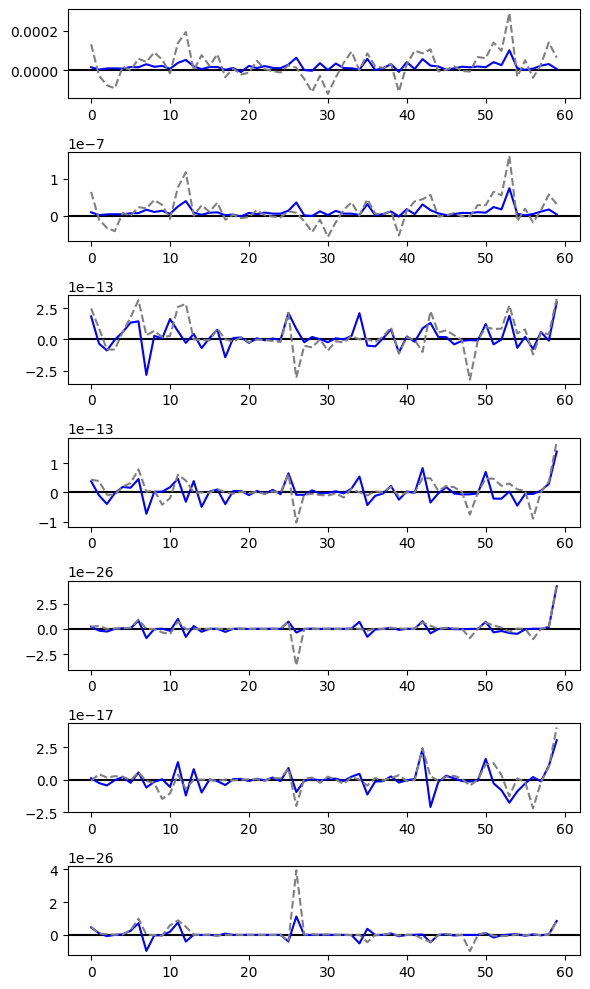

In [21]:
fig, axes = plt.subplots(7, 1, figsize=(6, 10))
for i in range(7):
    axes[i].axhline(0, color='black')
    axes[i].plot([distance_mother_hu[h].flatten()[i] if h not in peaks[0] else distance_half_hu[h].flatten()[i] for h in range(len(distance_mother_hu))], 'b')
    axes[i].plot([h.flatten()[i] for h in distance_control_hu], color='gray', linestyle='--')

plt.tight_layout()
plt.show()

## Check also Haralick features

In [23]:
print(len(mother_haralicks))
print(mother_haralicks[0].shape)

61
(4, 13)


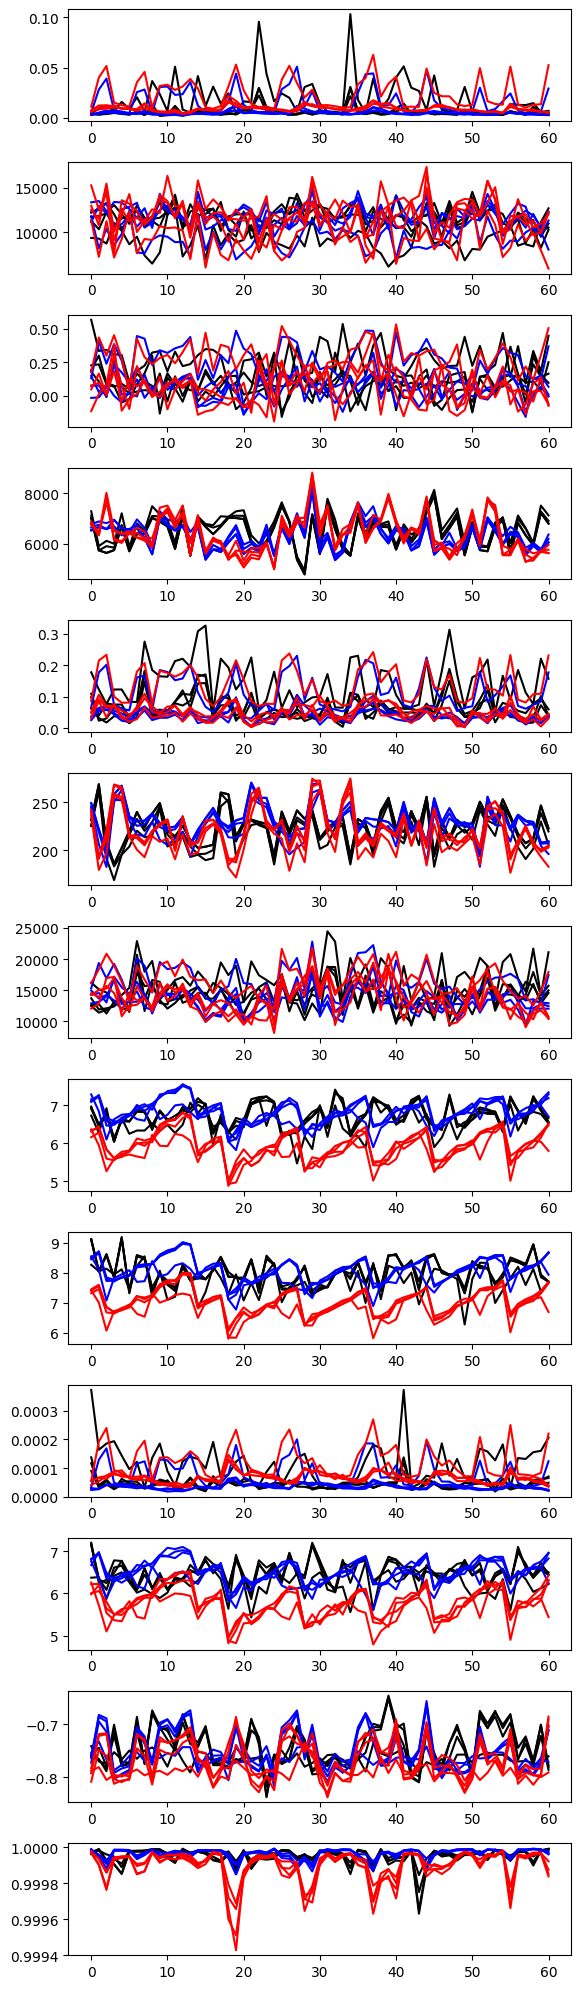

In [28]:
fig, axes = plt.subplots(13, 1, figsize=(6, 20))
for i in range(13):
    # axes[i].axhline(0, color='black')
    axes[i].plot([control_haralicks[random.randint(0, len(control_haralicks)-1)][:, i] for z in mother_haralicks], 'black')
    axes[i].plot([z[:, i] for z in mother_haralicks], 'b')
    axes[i].plot([z[:, i] for z in half_haralicks], 'r')
    # axes[i].plot([distance_mother_zer[z].flatten()[i] if z not in peaks[0] else distance_half_zer[z].flatten()[i] for z in range(len(distance_mother_zer)) ], 'b')
    # axes[i].plot([z.flatten()[i] for z in distance_control_zer], color='gray', linestyle='--')
    
plt.tight_layout()
plt.show()

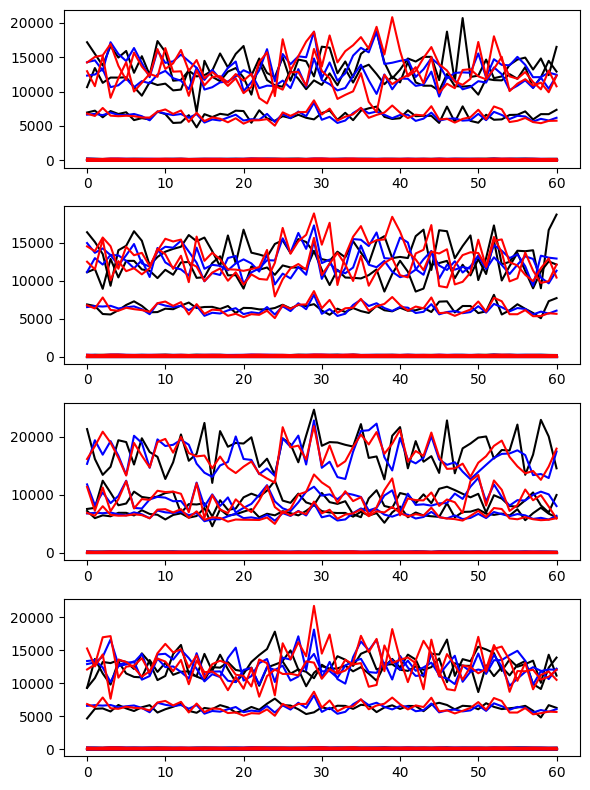

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(6, 8))
for i in range(4):
    # axes[i].axhline(0, color='black')
    axes[i].plot([control_haralicks[random.randint(0, len(control_haralicks)-1)][i, :] for z in mother_haralicks], 'black')
    axes[i].plot([z[i, :] for z in mother_haralicks], 'b')
    axes[i].plot([z[i, :] for z in half_haralicks], 'r')
    # axes[i].plot([distance_mother_zer[z].flatten()[i] if z not in peaks[0] else distance_half_zer[z].flatten()[i] for z in range(len(distance_mother_zer)) ], 'b')
    # axes[i].plot([z.flatten()[i] for z in distance_control_zer], color='gray', linestyle='--')
    
plt.tight_layout()
plt.show()

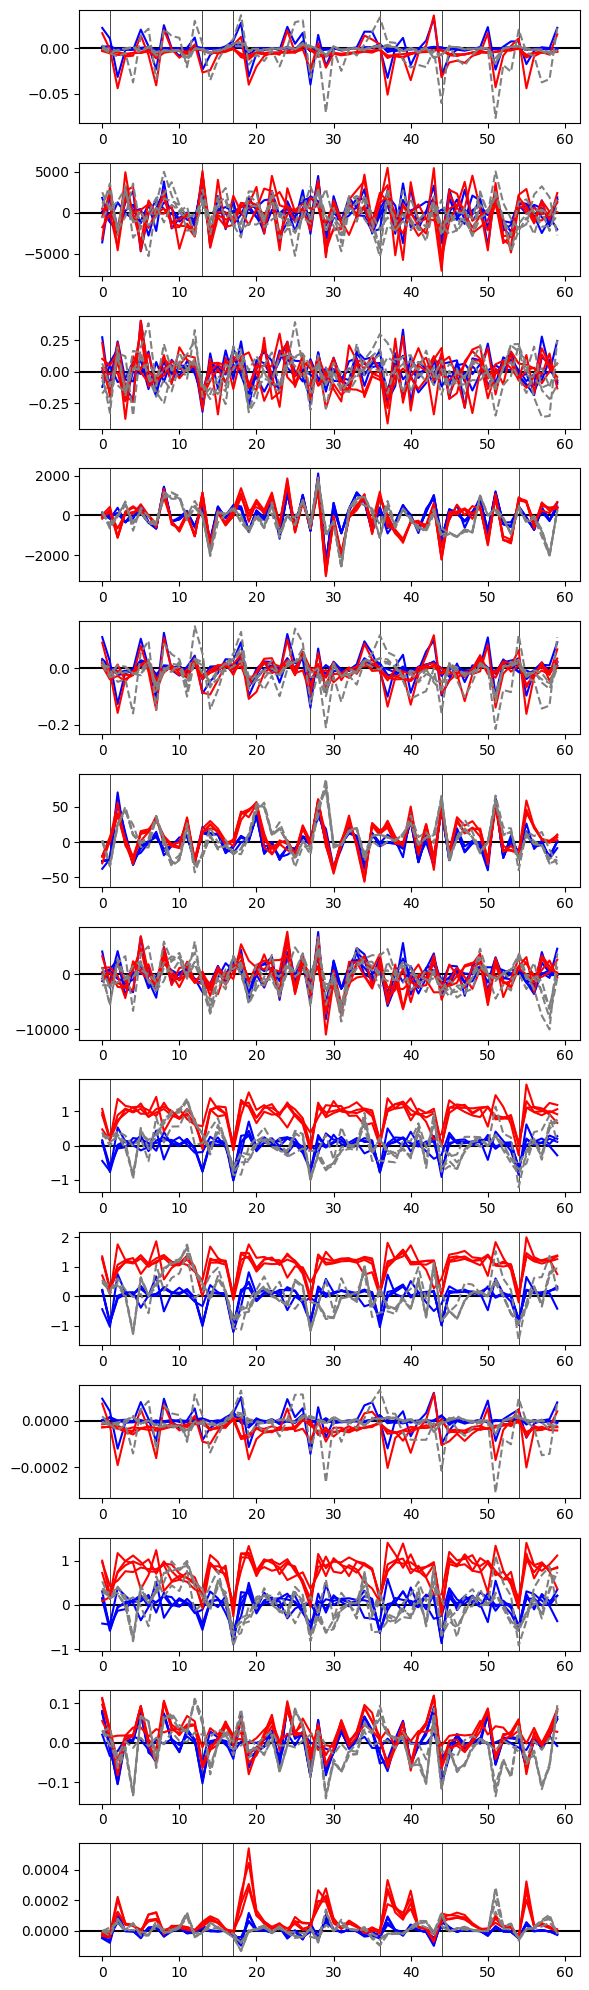

In [37]:
fig, axes = plt.subplots(13, 1, figsize=(6, 20))
for i in range(13):
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].axhline(0, color='black')
    axes[i].plot([z[:, i] for z in distance_mother_har], 'b')
    axes[i].plot([z[:, i] for z in distance_half_har], 'r')
    axes[i].plot([z[:, i] for z in distance_control_har], color='gray', linestyle='--')

plt.tight_layout()
plt.show()

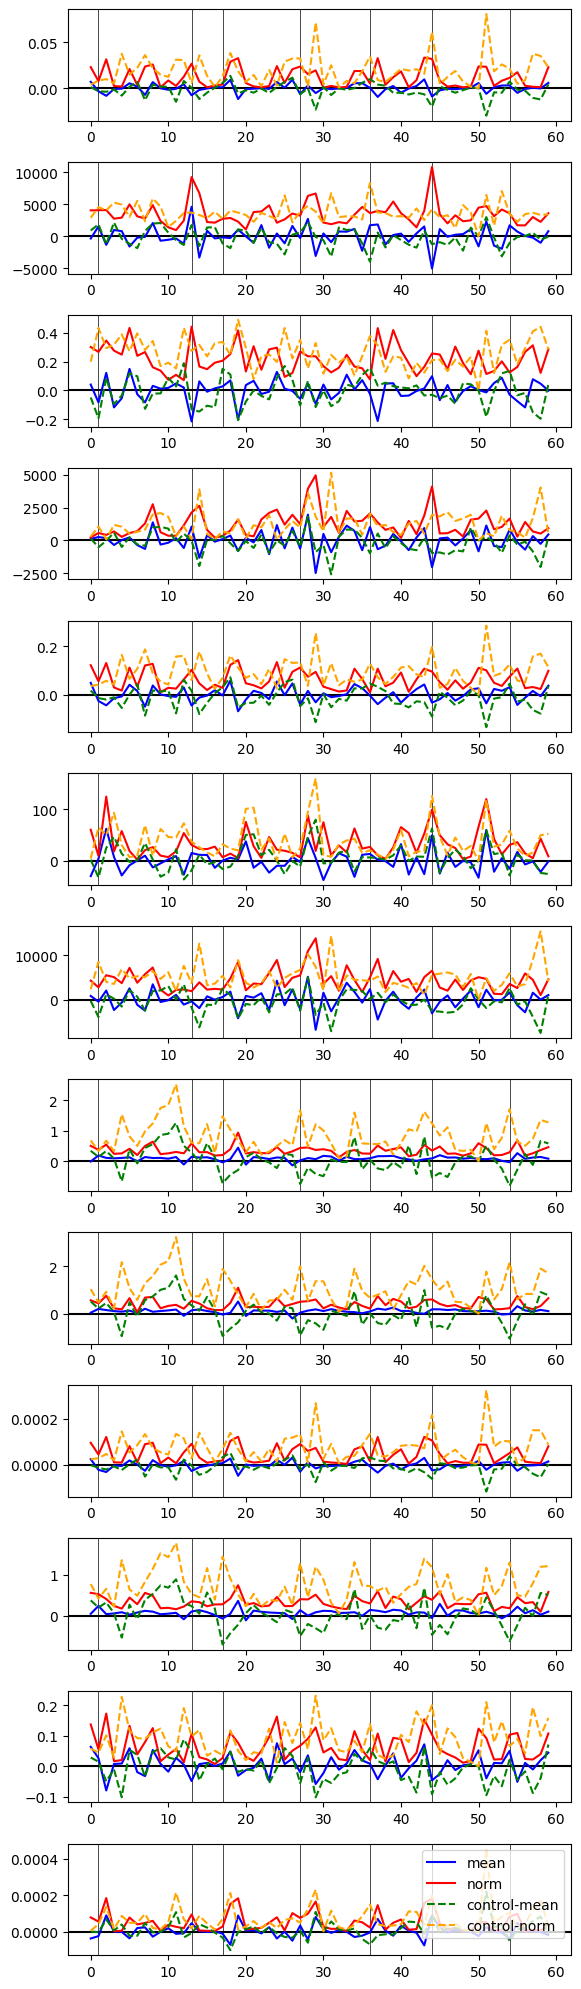

In [51]:
fig, axes = plt.subplots(13, 1, figsize=(6, 20))
for i in range(13):
    axes[i].axhline(0, color='black')
    for p in peaks[0]:
        axes[i].axvline(p, linewidth=0.5, color='black')
    axes[i].plot([np.mean(distance_mother_har[z][:, i]) 
                  if z not in peaks[0] 
                  else np.mean(distance_half_har[z][:, i]) 
                  for z in range(len(distance_mother_har))], 'b', label="mean")
    axes[i].plot([np.linalg.norm(distance_mother_har[z][:, i]) 
                  if z not in peaks[0] 
                  else np.linalg.norm(distance_half_har[z][:, i]) 
                  for z in range(len(distance_mother_har))], 'r', label="norm")
    axes[i].plot([np.mean(z[:, i]) for z in distance_control_har], color='green', linestyle='--', label="control-mean")
    axes[i].plot([np.linalg.norm(z[:, i]) for z in distance_control_har], color='orange', linestyle='--', label="control-norm")
    
plt.legend()
plt.tight_layout()
plt.show()

Some moments are useful! Is this the case for the particular cell or can be generalised?

From 8 to 13 seems useful, maybe just use the mean would be good enough